BloomTech Data Science

*Unit 2, Sprint 3, Module GIT project*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] If you haven't completed assignment #1, please do so first.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [ ] Fit a model. Does it beat your baseline? 
- [ ] Try xgboost.
- [ ] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.

But, if you aren't ready to try xgboost and permutation importances with your dataset today, that's okay. You can practice with another dataset instead. You may choose any dataset you've worked with previously.

The data subdirectory includes the Titanic dataset for classification and the NYC apartments dataset for regression. You may want to choose one of these datasets, because example solutions will be available for each.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 8
  - _**[Gradient Boosting Explained](https://www.gormanalysis.com/blog/gradient-boosting-explained/)**_ — Ben Gorman
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) — Alex Rogozhnikov
  - [How to explain gradient boosting](https://explained.ai/gradient-boosting/) — Terence Parr & Jeremy Howard

Data set: [Solar Power Generation Data](https://www.kaggle.com/anikannal/solar-power-generation-data?select=Plant_2_Weather_Sensor_Data.csv)

In [ ]:
%%capture
import sys
!pip install category_encoders==2.*
!pip install pdpbox
!pip install shap
data = 'Plant_1_Generation_Data.csv'

In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error r2_score
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve,roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingClassifier
from category_encoders import OneHotEncoder, OrdinalEncoder
from xgboost import XGBClassifier 
from sklearn.inspection import permutation_importance 
from xgboost import XGBRegressor
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')
import shap
import numpy as np
from numpy import log1p

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def wrangle(filepath):
  df = pd.read_csv(filepath,
                 parse_dates=['DATE_TIME']).set_index('DATE_TIME'
                 )
 # Create target column...

  return df
df = wrangle(data)

 #Drop non-unique PLANT_ID
df = df.drop('PLANT_ID', 1)

df.rename(columns = {'DATE_TIME':'date', 
                  'SOURCE_KEY':'id',
                  'DC_POWER':'dc',
                  'AC_POWER':'ac',
                  'DAILY_YIELD':'daily_yield',
                  'TOTAL_YIELD':'total_yield'}, inplace=True)
  #Drop HCCC
df = df.drop('id', 1)
  #Drop potentially leaky columns
df = df.drop('total_yield', 1)


In [ ]:
df.head()

,dc,ac,daily_yield
DATE_TIME,,,
2020-05-15,0.0,0.0,0.0
2020-05-15,0.0,0.0,0.0
2020-05-15,0.0,0.0,0.0
2020-05-15,0.0,0.0,0.0
2020-05-15,0.0,0.0,0.0


In [ ]:
df= df[df['dc'] != 0]

In [ ]:
df.describe()


,dc,ac,daily_yield
count,36827.000000,36827.000000,36827.000000
mean,5878.124201,574.851541,3603.919501
std,3791.741162,370.119059,2692.146275
min,8.750000,0.850000,0.000000
25%,2365.857143,232.006250,904.250000
50%,5969.142857,584.862500,3580.285714
75%,8889.008928,869.226786,5909.008928
max,14471.125000,1410.950000,9162.857143


In [ ]:
threshold = 2_000

sub_optimal =  df[df['daily_yield'] < threshold]
sub_optimal.tail()

,dc,ac,daily_yield
DATE_TIME,,,
2020-06-17 11:00:00,6391.142857,625.957143,1908.000000
2020-06-17 11:00:00,6737.000000,659.300000,1871.571429
2020-06-17 11:00:00,6718.000000,657.785714,1920.428571
2020-06-17 11:15:00,7522.750000,736.525000,1985.750000
2020-06-17 11:15:00,7388.875000,723.475000,1958.250000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8b03b4c910>,
      dtype=object)

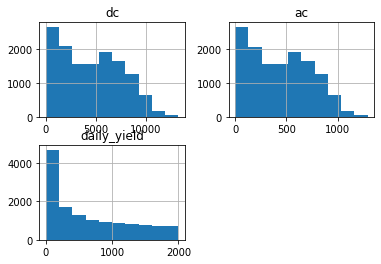

In [ ]:
sub_optimal.hist()
# I notice there is a skew on daily_yield, so I will np.log1p

In [ ]:
y_train_log = np.log1p(df['daily_yield'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8b0397a650>,
      dtype=object)

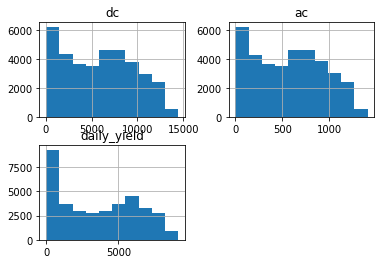

In [ ]:
df.hist()

In [ ]:
target = 'daily_yield'
y = df[target]
X = df.drop(target, axis=1)
#I set my target and do my first split

In [ ]:
X_train1, X_test, y_train1, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train1, y_train1, test_size=0.20, random_state=42)
#On my next split, I randomize the split between train, test and validation data
#I could have split it by date, but chose not to.

In [ ]:
print('Mean daily yield:', y_train.mean())

y_pred = [y_train.mean()] * len(y_train)
print('Baseline MAE:', mean_absolute_error(y_train, y_pred))

Mean daily yield: 3603.351678039211
Baseline MAE: 2401.571301712662


In [ ]:
model_lr = LinearRegression()

In [ ]:
model_lr.fit(X_train,y_train)

LinearRegression()

In [ ]:
print('Training MAE:', mean_absolute_error(y_train,model_lr.predict(X_train)))
print('Test MAE:', mean_absolute_error(y_test,model_lr.predict(X_test)))

Training MAE: 2394.0104168522867
Test MAE: 2362.2888772051897


In [ ]:
print("R-Squared:",r2_score(y_train, model_lr.predict(X_train)))
print("R-Squared:",r2_score(y_test,model_lr.predict(X_test)) )

R-Squared: 0.004991260216618332
R-Squared: 0.004932605450963301


In [ ]:
print("R-Squared:", model_lr.score(X_train, y_train))
print("R-Squared:", model_lr.score(X_test, y_test))

R-Squared: 0.004991260216618332
R-Squared: 0.004932605450963301


In [ ]:
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBRegressor(random_state=42,n_estimator=25, n_jobs=-1) 
)

model_xgb.fit(X_train, y_train)

[00:44:53] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer()),
                ('xgbregressor',
                 XGBRegressor(n_estimator=25, n_jobs=-1, random_state=42))])

In [ ]:
model_XGB1 = XGBRegressor(random_state=42, n_jobs=-1)
model_XGB1.fit(X_train, y_train);

[00:54:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
model_perm = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='mean'),
    XGBRegressor(random_state=42,n_estimator=25, n_jobs=-1)
)

model_perm.fit(X_train, y_train)

[00:44:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(steps=[('ordinalencoder', OrdinalEncoder(cols=[], mapping=[])),
                ('simpleimputer', SimpleImputer()),
                ('xgbregressor',
                 XGBRegressor(n_estimator=25, n_jobs=-1, random_state=42))])

In [ ]:
features = ['ac','dc']

In [ ]:
interact= pdp_interact(
    model_xgb,
    dataset= X_val, 
    model_features=X_val.columns,
    features=features
)

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8afc7a5810>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f8afc7cfd90>})

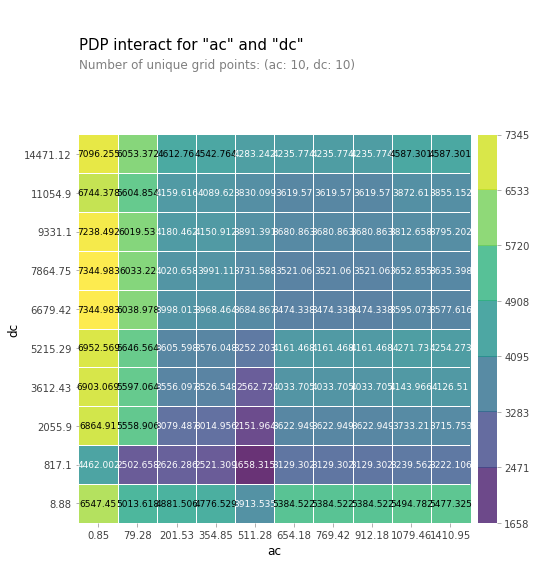

In [ ]:
pdp_interact_plot(interact,plot_type='grid', feature_names=features)

In [ ]:
shap_row = X_val.tail(1)

In [ ]:
explainer = shap.TreeExplainer(model_XGB1)

In [ ]:
shap_values = explainer.shap_values(shap_row)

shap.initjs()
shap.force_plot(
    base_value= explainer.expected_value,
    shap_values=shap_values,
    features=shap_row
)

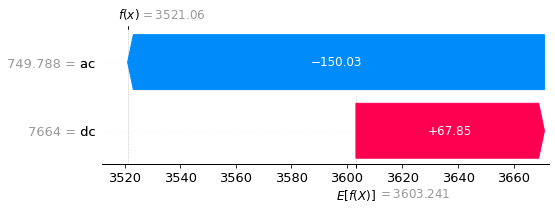

In [ ]:
explainer = shap.TreeExplainer(model_XGB1)
shap_values = explainer(shap_row)
shap.plots.waterfall(shap_values[0])